In [1]:
%load_ext autoreload 
%autoreload 2 

In [33]:
from generative_social_choice.datasets.datasets import get_dataset
from generative_social_choice.experiments.prolific_approval_query_eval.create_agents import (
    extract_statement_from_question,
)
import re
import random
from generative_social_choice.experiments.openai_jr_demo.compute_matching import (
    optimize_monroe_matching,
)
import pandas as pd
import matplotlib.pyplot as plt

In [16]:
dataset = get_dataset("prolific")
EXPERIMENTS = [
    "chatbot_personalization_eval_23_09_28",
    "chatbot_personalization_eval_23_09_28_v2",
    "chatbot_personalization_eval_23_09_28_strict",
]
vote_step_numbers = [9, 11, 13, 15, 17, 19]

Pick which experiment data to use

In [17]:
experiment_name = EXPERIMENTS[2]

Set up df with utility data 

In [18]:
agent_ids = dataset.get_agent_ids()[experiment_name]
df = dataset.load()
df = df[
    (df["experiment_name"] == experiment_name) & (df["step"].isin(vote_step_numbers))
]
df["statement"] = df["question_text_parsed"].apply(
    lambda question: extract_statement_from_question(
        experiment_name=experiment_name, question=question
    )
)
pivot_df = df.pivot(index="user_id", columns="statement", values="choice")

Remove some agents to get a multiple of k. (randomly)

In [20]:
# Round number of agents down so it's a multiple of the number of statements
random.seed(0)
BAD_AGENTS = ["5723c21ca300060009bc6d9d"]  # put 0 for everything
num_all_agents = pivot_df.shape[0]
num_statements = pivot_df.shape[1]
num_sampled_agents = num_statements * (num_all_agents // num_statements)
sampled_agents = random.sample(
    list(set(pivot_df.index).difference(BAD_AGENTS)), num_sampled_agents
)
pivot_df = pivot_df[pivot_df.index.isin(sampled_agents)]

Compute optimal matching

In [21]:
utilities = pivot_df.values.astype(int).tolist()
matching = optimize_monroe_matching(utilities=utilities)

Restricted license - for non-production use only - expires 2024-10-28
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel(R) Core(TM) i5-9400H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 30 rows, 144 columns and 288 nonzeros
Model fingerprint: 0x93b4954e
Variable types: 0 continuous, 144 integer (144 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+00]
Found heuristic solution: objective 74.0000000
Presolve time: 0.00s
Presolved: 30 rows, 144 columns, 288 nonzeros
Variable types: 0 continuous, 144 integer (144 binary)

Root relaxation: objective 9.100000e+01, 41 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node 

Compute utilities of agents under matching

In [22]:
pivot_df["assignments"] = matching
pivot_df["utility"] = pivot_df.apply(lambda row: row[row["assignments"]], axis=1)
pivot_df["utility"]

user_id
56ee521a65ca4d000cc39e55    4
5716afefc5aca2000a8d4546    4
5b33034d975e260001e981c9    3
5b666901f7798c000182c01c    4
5c3820ee1ede2b0001155929    4
5dea10b4446c9012dc5e3fe3    4
5e6b034bffc1a90c3fe8c234    4
5ed696d2449ef00dbdce0178    4
5eda5c5faf7c7f08a2f68cb7    4
5f01230b4f8dff26fad883d2    4
5f07e040943fa520130a9f9b    4
5f6592b0534630116af73d11    4
60fdaef9697a239debe0fdc7    4
60ff830d7a7cce48e1787ba2    4
614f6ee64db7dc70a6822753    3
627f0b3c5f54598f7d496fb3    4
62d76226d4848594e77ef056    4
62e405958a2c7c7e7f98e8fd    4
63be6aae1b65a42e794770ee    4
63ea55fe1aee6acc422270f0    4
63f02c686a43074bf1a16dc8    2
6449c06515cda31d2f043b42    3
6455b4121cd3166666ae1fdd    4
648247f1a39f941af3429342    4
Name: utility, dtype: object

In [23]:
pivot_df

statement,"Chatbot personalization can be beneficial for user experience, but it should be implemented carefully and cautiously, as there are potential risks associated with trusting service creators and managers with sensitive user information, which may be exploited for nefarious or invasive purposes.","Chatbots should be personalized to a limited extent for the sake of user experience and efficiency, but not to the point that it would compromise privacy, safety, or encourage users to be overly reliant on AI for information; additional personalization should only be applied if it can be corroborated and reasonably neutralized when necessary.","Chatbots should be personalized to a limited extent using only the information explicitly provided by users during conversations, without delving into their search history or advertisement preferences, to maintain a balance between personalization and user privacy while avoiding data monopolization by chatbot companies.","Chatbots should be personalized to a limited extent, just enough to enhance user experience without compromising their ability to provide unbiased information, while ensuring user privacy and data security are maintained through responsible data handling and transparency.","Chatbots should be personalized to improve user experience, but with options for users to control the level of personalization and privacy, ensuring user trust and data security.","Personalizing chatbots should be embraced, as it can enhance user experience and be resource-efficient, provided that proper programming and safety measures are in place to mitigate potential dangers and maintain user well-being.",assignments,utility
user_id,,,,,,,,
56ee521a65ca4d000cc39e55,3,2,3,4,4,3,3,4
5716afefc5aca2000a8d4546,4,3,4,4,2,2,3,4
5b33034d975e260001e981c9,3,3,3,2,3,2,1,3
5b666901f7798c000182c01c,3,4,3,2,4,4,5,4
5c3820ee1ede2b0001155929,4,4,4,4,4,3,4,4
5dea10b4446c9012dc5e3fe3,4,1,4,3,4,3,2,4
5e6b034bffc1a90c3fe8c234,1,3,4,4,1,0,3,4
5ed696d2449ef00dbdce0178,3,3,1,3,4,4,5,4
5eda5c5faf7c7f08a2f68cb7,2,4,4,4,4,2,2,4


## Charts showing frequencies and stuff

Overall frequency of human votes

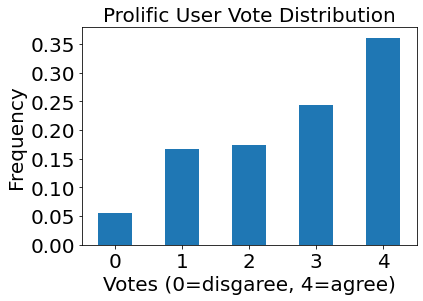

In [45]:
flattened_values = pd.Series(
    pivot_df.drop(columns=["assignments", "utility"], axis=1).values.ravel()
)
fontsize = 20
value_counts = flattened_values.value_counts(normalize=True).sort_index()
value_counts.plot(kind="bar", fontsize=fontsize)
plt.xlabel("Votes (0=disgaree, 4=agree)", fontsize=fontsize)
plt.ylabel("Frequency", fontsize=fontsize)
plt.xticks(rotation=0)
plt.title("Prolific User Vote Distribution", fontsize=fontsize)
plt.show()

swarm plot of how popular statements are

/home/sara/.local/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 12.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/sara/.local/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 8.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/tmp/ipykernel_196728/2387370614.py:6: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.xticks([], [])
/home/sara/.local/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 12.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/sara/.local/lib/python3.10/site-packages/seaborn/categorica

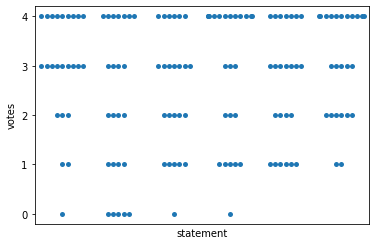

In [53]:
import seaborn as sns

melted_df = pivot_df.drop(columns=["assignments", "utility"], axis=1).melt(
    var_name="statement", value_name="votes"
)
melted_df["votes"] = melted_df["votes"].astype(int)
melted_df = melted_df.sort_values("votes")
sns.swarmplot(x="statement", y="votes", data=melted_df)
plt.xticks([], [])
plt.yticks(range(0, 5))
plt.show()